In [2]:
import tensorflow
import os
import shutil
import keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pandas as pd
import joblib
import tensorflow_addons as tfa
import tempfile
import seaborn as sns


c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\graffiti_prediction_model\.venv\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\graffiti_prediction_model\.venv\Lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.15.0 and is not supp

### Defining Model Structure

Here we define our model structure using data augmentation to augment are training dataset and then call this function to create a model.

In [3]:
image_height, image_width = 500, 500
batch_size = 256
epochs = 10

def create_model(image_height, image_width, threshold):

    # Defining data augmentation layer
    data_augmentation = keras.Sequential([
            keras.layers.RandomFlip("horizontal_and_vertical"),
            keras.layers.RandomRotation(0.2),
            ])
    #Defining model
    model = keras.Sequential([
            data_augmentation,
            keras.layers.Rescaling(1./255),
            keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(image_height, image_width, 3)),
            keras.layers.MaxPool2D((2, 2)),
            keras.layers.Conv2D(32, (3, 3), activation='relu'),
            keras.layers.MaxPool2D((2, 2)),
            keras.layers.Conv2D(64, (3, 3), activation='relu'),
            keras.layers.MaxPool2D((2, 2)),
            keras.layers.Flatten(),
            keras.layers.Dense(512, activation='relu'),
            keras.layers.Dense(1, activation='sigmoid')
        ])
        
    #Compling model
    model.compile(loss='binary_crossentropy',
                        optimizer='adam', 
                        metrics=[tfa.metrics.F1Score(num_classes = 2, threshold = threshold, average="micro")])
    return model

def plot_result(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

def plot_cm(labels, predictions, threshold=0.5):
  cm = confusion_matrix(labels, predictions > threshold)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(threshold))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

In [4]:
# Creating model for 500 x 500 image with a 0.5 classification threshold
my_model = create_model(image_height, image_width, 0.5)

### Loading Data
Reaing in the images from our directory

In [5]:
# Path to read data from
data_dir = './Data-Clean/'

# Defining train an validation splits using 80/20 split
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size)

Found 19981 files belonging to 2 classes.
Using 15985 files for training.
Found 19981 files belonging to 2 classes.
Using 3996 files for validation.


### Visualizing Data

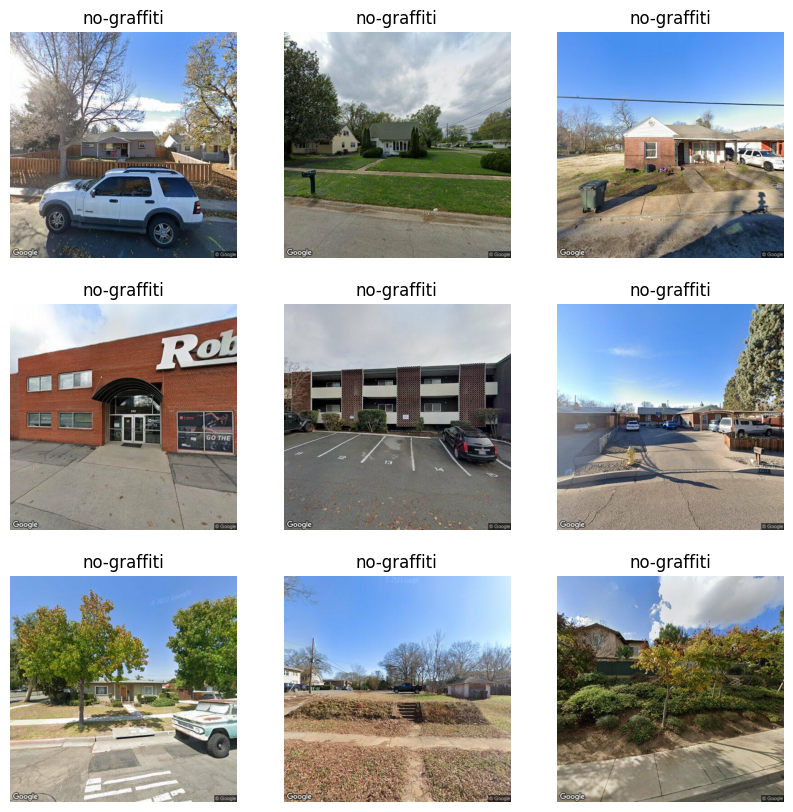

In [6]:
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Training Model

Now that we have our training data and model defined we can now train it

In [7]:
history = my_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10



10/63 [===>..........................] - ETA: 12:52 - loss: 0.3690 - f1_score: 0.9945

: 

In [ ]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
my_model.save_weights(initial_weights)

### Evaluating Performence

In [ ]:
# First making predictions on test and train datasets
train_predictions_baseline = my_model.predict(train_ds, batch_size=batch_size)
test_predictions_baseline = my_model.predict(val_ds, batch_size=batch_size)

In [ ]:
# Generating confusion matrix on test set
plot_cm(val_ds.labels, test_predictions_baseline)

In [ ]:
# Plotting loss over training epochs
plot_result(history)

### Retraining Model with Higher Classification Threshold
This will help eliminate false positives and address our imbalanced dataset

In [ ]:
second_model = create_model(image_height, image_width, 0.9)
second_history = second_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

In [ ]:
test_predictions_high_threshold = second_model.predict(val_ds, batch_size=batch_size)

Now we'll evluate performance of our second model with the 0.9 classification threshold

In [ ]:
# Generating confusion matrix on test set
plot_cm(val_ds.labels, test_predictions_high_threshold)

In [ ]:
# Plotting loss over training epochs
plot_result(history)